In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Activation
from sklearn.metrics import r2_score

In [13]:
data = pd.read_csv('dataset.csv')

In [14]:
def one_hot_encode(smiles):
    
    char_list = ['c', 'n', 'o', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.', '-', '=', '#', '$', ':', '/', '+', ')', '(', '@', '{', '}', '\\', ' ', '[', ']']
    char_dict = {char:i for i,char in enumerate(char_list)}

    nd = len(char_dict)
    npos_max = data['SMILES'].apply(len).max()

    encoding = np.zeros((npos_max, nd))
    c = 0

    for i in range(len(smiles)):
        if smiles[i] in char_dict:
            if i + 1 < len(smiles) and smiles[i:i+2] in char_dict:
                encoding[i-c, char_dict[smiles[i:i+2]]] = 1
                c += 1
            else:
                encoding[i-c, char_dict[smiles[i]]] = 1

    return encoding

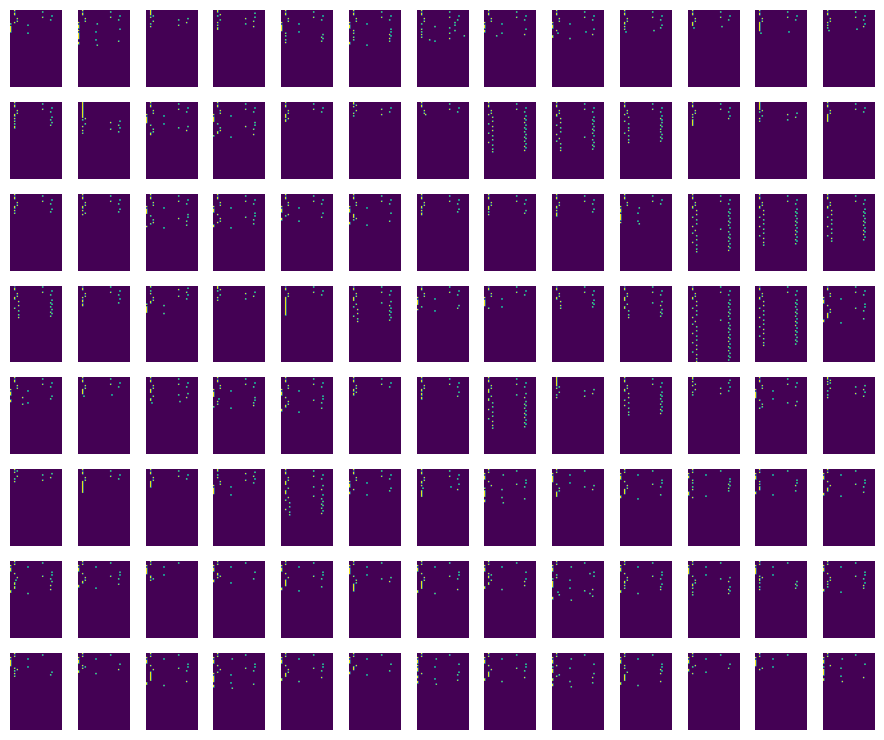

In [24]:
fig, axs = plt.subplots(8, 13, figsize=(9, 7.5))
axs = axs.flatten()

for i, smiles in enumerate(data['SMILES']):
    encoding = one_hot_encode(smiles)
    axs[i].imshow(encoding)
    axs[i].axis('off')

plt.tight_layout()
plt.savefig('all_images.png')

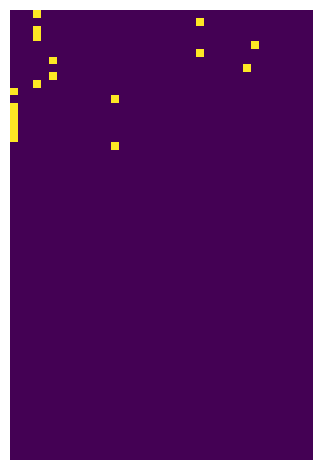

In [25]:
plt.imshow(one_hot_encode(data['SMILES'][0]))
plt.axis('off')
plt.tight_layout()
plt.savefig('one_image.png')

In [17]:
X = np.stack([np.expand_dims(one_hot_encode(smiles), 2) for smiles in data['SMILES']])
y = np.expand_dims(np.array(data['Tg']), 1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [19]:
model = Sequential()

model.add(ZeroPadding2D(5, input_shape=X[0].shape))

model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3)))

model.add(Flatten())

model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2, seed=0))

model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 68, 49, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 47, 256)       2560      
_________________________________________________________________
batch_normalization_3 (Batch (None, 66, 47, 256)       1024      
_________________________________________________________________
activation_3 (Activation)    (None, 66, 47, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 15, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 13, 128)       295040    
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 13, 128)      

In [20]:
history = model.fit(X_train, y_train, epochs=500, batch_size=15, verbose=0, validation_split=0.1)

final_train_loss = model.evaluate(X_train, y_train, batch_size=1, verbose=0)
final_test_loss = model.evaluate(X_test, y_test, verbose=0)
y_train_pred = model.predict(X_train, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)
r2_score_train = r2_score(y_train, y_train_pred)
r2_score_test = r2_score(y_test, y_test_pred)

print('Final Train Loss (%) = ', final_train_loss)
print('Final Test Loss (%) = ', final_test_loss)
print('R2 Score Train = ', r2_score_train)
print('R2 Score Test = ', r2_score_test)

Final Train Loss (%) =  2.9946036338806152
Final Test Loss (%) =  5.471070766448975
R2 Score Train =  0.9643016147294222
R2 Score Test =  0.8146777122173801


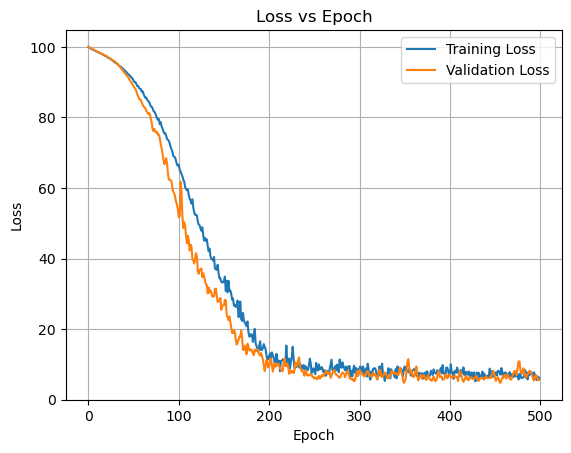

In [26]:
plt.figure()
plt.grid()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.savefig('loss.png')

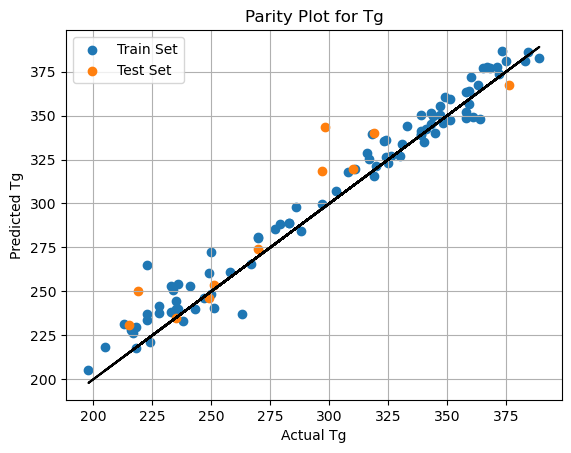

In [27]:
plt.figure()
plt.grid()
plt.scatter(y_train, y_train_pred)
plt.scatter(y_test, y_test_pred)
plt.plot(y, y, 'k-')
plt.xlabel('Actual Tg')
plt.ylabel('Predicted Tg')
plt.title('Parity Plot for Tg')
plt.legend(['Train Set', 'Test Set'])
plt.savefig('parity_plot.png')